In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kernel import Kernel

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"
plt.rc('text', usetex=True)

In [4]:
def generate_random_sphere(n_train, m):
    u = np.random.randn(n_train, m)
    u /= np.sqrt(np.sum(u**2, axis=1))[:, np.newaxis]
    return u

def get_stepsize(T, gamma_0=1):
    gamma = np.arange(T, dtype=float)
    gamma += 1
    np.sqrt(gamma, out=gamma)
    np.divide(1, gamma, out=gamma)
    gamma *= gamma_0
    return gamma

def median_error(y_pred, y_test, inplace=True):
    if inplace:
        err = y_pred
        err -= y_test
    else:
        err = y_pred - y_test
    err **= 2
    err = np.sum(err, axis=1)
    np.sqrt(err, out=err)
    np.abs(err, out=err)
    return err.mean()

def mean_error(y_pred, y_test, inplace=True):
    if inplace:
        err = y_pred
        err -= y_test
    else:
        err = y_pred - y_test
    err **= 2
    err *= err.shape[1]
    err = np.mean(err)
    return np.sqrt(err)

In [5]:
useful_col = [49, 50, 52, 54, 55, 56, 57]
df = pd.read_csv('bottle.csv', usecols=useful_col, dtype=float)
# print(df.count())
df.dropna(inplace=True)
df.set_index(np.arange(len(df)), inplace=True)

In [6]:
input_col = ['R_Depth', 'R_TEMP', 'R_SALINITY', 'R_SVA', 'R_DYNHT']
output_col = ['R_O2Sat']

n_train = 500000
causal = True

if causal:
    # Training set
    x_train = df.iloc[:n_train][input_col].values
    y_train = df.iloc[:n_train][output_col].values

    # Testing set
    x_test = df.iloc[n_train:][input_col].values
    y_test = df.iloc[n_train:][output_col].values
else:
    # Training set
    index_train = np.random.choice(len(df), n_train, replace=False)
    x_train = df.iloc[index_train][input_col].values
    y_train = df.iloc[index_train][output_col].values

    # Testing set
    index_test = np.ones(len(df), dtype=np.bool_)
    index_test[index_train] = False
    x_test = df.iloc[index_test][input_col].values
    y_test = df.iloc[index_test][output_col].values

# Normalization
x_mean = x_train.mean(axis=0)
x_std = x_train.std(axis=0)

x_train -= x_mean
x_train /= x_std
x_test -= x_mean
x_test /= x_std

# Normalized output (the easy part to learn)
y_mean = y_train.mean(axis=0)
y_std = y_train.std(axis=0)
y_train -= y_mean
y_train /= y_std
y_test -= y_mean
y_test /= y_std

In [7]:
def easiest_baseline():
    print(median_error(np.zeros(y_test.shape), y_test))
    
easiest_baseline()

0.8799277056351197


In [8]:
# Linear regression baseline
def lin_reg_sol(x, y, lambd):
    n, d = x.shape
    A = x.T @ x
    A /= n
    A += lambd * np.eye(d)
    b = x.T @ y
    b /= n
    return np.linalg.solve(A, b)

def linreg_baseline():
    w = lin_reg_sol(x_train, y_train, 0)
    y_pred = x_test @ w
    linreg_baseline = median_error(y_pred, y_test)
    return linreg_baseline

print(linreg_baseline())

0.20340980046708254


In [9]:
def krr_baseline():
    # Kernel ridge regression baseline
    sigma = 3e0
    kernel = Kernel('gaussian', sigma=sigma)

    # Function parameterization
    n_repr = 100
    ind = np.random.choice(len(x_train), n_repr, replace=True)
    x_repr = x_train[ind]
    kernel.set_support(x_repr)
    K = kernel(x_repr)
    lambd = 1e-6 * n_repr
    K += lambd * np.eye(len(K))
    alpha = np.linalg.solve(K, y_train[ind])

    y_pred = kernel(x_test).T @ alpha
    krr_baseline = mean_error(y_pred, y_test)
    print(krr_baseline)

krr_baseline()

0.18791835033300175


In [10]:
# Descent parameters
gammas = [1e0]
num_it = n_train
resampling = False

# Randomness control
np.random.seed(0)

# Random questions
n_train, m = y_train.shape
u = generate_random_sphere(num_it, m)
v = .3 * np.random.randn(num_it)

# Kernel
sigma = 3e0
kernel = Kernel('gaussian', sigma=sigma)
lambd = 1e-6

# Function parameterization
n_repr = 100
ind = np.random.choice(n_train, n_repr, replace=True)
x_repr = x_train[ind]
kernel.set_support(x_repr)
K_repr = kernel.get_k()

# Assume that parameters where initialized around a good model
def good_init():
    K = kernel(x_repr)
    lambd = 1e-6 * n_repr
    K += lambd * np.eye(len(K))
    return np.linalg.solve(K, y_train[ind])

theta_init = good_init()
theta_init += 1e0 * np.random.randn(*theta_init.shape)

# Small testset
n_small_test = 10000
ind = np.random.choice(len(x_test), n_small_test, replace=True)
x_small_test = x_test[ind]
y_small_test = y_test[ind]
K_test = kernel(x_small_test).T

# Placeholders
full_error_w = np.zeros((num_it, len(gammas)))
full_error_f = np.zeros((num_it, len(gammas)))
theta_w = np.empty((n_repr, 1))
theta_ave_w = np.empty((n_repr, 1))
theta_f = np.empty((n_repr, 1))
theta_ave_f = np.empty((n_repr, 1))
grad = np.empty(theta_w.shape)
K_train = kernel(x_repr[:1]).T

if resampling:
    I = np.random.choice(n_train, num_it, replace=True)
else:
    I = np.arange(num_it)

for i_g, gamma_0 in enumerate(gammas):
    gamma = get_stepsize(num_it, gamma_0)

    # Descent initialization
    theta_w[:] = theta_init
    theta_f[:] = theta_init
    theta_ave_f[:] = 0
    theta_ave_w[:] = 0

    for i in range(num_it):
        # New point
        ind = I[i]
        K_train[:] = kernel(x_train[ind:ind+1]).T

        # Active update
        epsilon = np.sign((K_train @ theta_w - y_train[ind]) @ u[i])
        grad[:] = 1
        grad *= u[i]
        grad *= K_train.T
        grad *= epsilon
        grad += lambd * K_repr @ theta_w
        grad *= gamma[i]
        theta_w -= grad

        # Passive update
        eps_sig = np.sign((y_train[ind] @ u[i]) - v[i])
        eps_fun = np.sign(((K_train @ theta_f) @ u[i]) - v[i])
        if eps_sig != eps_fun:
            grad[:] = 1
            grad *= u[i]
            grad *= K_train.T
            grad *= eps_fun
            grad += lambd * K_repr @ theta_f
            grad *= gamma[i]
            theta_f -= grad

        # Averaging iterates
        theta_ave_w *= i
        theta_ave_w += theta_w
        theta_ave_w /= (i+1)
        theta_ave_f *= i
        theta_ave_f += theta_f
        theta_ave_f /= (i+1)

        y_pred_w = K_test @ theta_ave_w
        full_error_w[i, i_g] = median_error(y_pred_w, y_small_test)

        y_pred_f = K_test @ theta_ave_f
        full_error_f[i, i_g] = median_error(y_pred_f, y_small_test)
        if not i % int(1e4):
            print(i//int(1e4), end=',')

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,

/Users/vivien/.conda/miniconda3/envs/dev/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


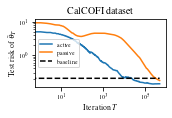

In [11]:
fig, ax = plt.subplots(figsize=(2.5, 1.75))
for i in range(len(gammas)):
    a, = ax.plot(full_error_w[30:, i])
    b, = ax.plot(full_error_f[30:, i])

c, = ax.plot(np.arange(n_train-30), np.full(n_train-30, linreg_baseline()), c='k', linestyle='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend([a, b, c], ['active', 'passive', 'baseline'], prop={'size': 6})

plt.yticks(fontsize=6)
plt.xticks(fontsize=6)
ax.set_title(r"CalCOFI dataset", size=10)
ax.set_xlabel(r"Iteration $T$", size=8)
ax.set_ylabel(r"Test risk of $\bar\theta_T$", size=8)
fig.tight_layout()
fig.savefig("calcofi.pdf")